In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import psycopg2
import seaborn as sns

sns.set_style("whitegrid")
import statsmodels.formula.api as sm
from export_regression_lib import trained_model, odds_ratio, independent_variable_stats
from export_regression_lib import (
    standardized_features,
    simulating_features,
    simulate_continuous_outcomes,
)

# START HERE
## The cell below contains all the mission specific data. Here you will specifity, the independent variables, the dependent variable, and the definitions of positive and negative outcome.

In [3]:
# CHANGE THESE VALUES
# ONLY USE SINGLE QUESTIONS FOR DEPENDENT AND INDEPENDENT VARIABLES IN FORMAT 'PART_NUM-QUESTION_NUM'
continuous_independent_variables = [
    "Q30", 'Q33', 'Q36', 'Q41'

]
# NOTE MULTIPLE QUESTIONS NEED TO BE CATEGORICAL
categorical_independent_variables = ['Q39', 'Q42']
categorical_dict = {'Q39': 'Urban', 'Q42': 'Republican',  'Q43': 'Donald Trump'}
dependent_variable = "Q19_4"
negative_outcomes = ["3","4"]
positive_outcomes = ["1","2"]
grouping = 'rid'

data_file_name = 'data_files/hot_takes_data.csv'
encoded_file_name = 'data_files/hot_takes_encoded.csv'

# After entering the information above, go to Cell -> Run All to see your regression results

In [5]:
data = pd.read_csv(data_file_name).drop([0,1])
encoded_data = pd.read_csv(encoded_file_name).drop([0,1])
continuous_data = encoded_data[continuous_independent_variables + ['rid', dependent_variable]].dropna()
for cat in categorical_independent_variables:
    data[cat] = data[cat].str.replace("\t"," ")
for cont in continuous_independent_variables + [dependent_variable]:
    continuous_data[cont] = continuous_data[cont].astype(int)

In [6]:
def get_outcome(response, positive_outcomes, negative_outcomes):
    if str(response) in positive_outcomes:
        return 1
    elif str(response) in negative_outcomes:
        return 0
    else:
        return None

In [7]:
dummy_df = pd.DataFrame()
for cat in categorical_independent_variables:
    temp_dummy_df = pd.get_dummies(data[["rid", cat]].dropna(), columns=[cat])
    if len(dummy_df) > 0:
        dummy_df = pd.merge(
            dummy_df,
            temp_dummy_df[
                [
                    col
                    for col in list(temp_dummy_df)
                    if not col.endswith(categorical_dict[cat])
                ]
            ],
            on="rid",
        )
    else:
        dummy_df = temp_dummy_df[
            [
                col
                for col in list(temp_dummy_df)
                if not col.endswith(categorical_dict[cat])
            ]
        ]
continuous_data['outcome'] = encoded_data.apply(
    lambda row: get_outcome(row[dependent_variable], positive_outcomes, negative_outcomes),
    axis=1
)
full_data = pd.merge(
    continuous_data,
    dummy_df,
    on='rid'
)
features = [f for f in list(full_data) if f not in ['rid', 'outcome', dependent_variable]]
categorical_features = [f for f in features if any([f.startswith(cf) for cf in categorical_independent_variables])]

In [8]:
full_data.corr()

,Q30,Q33,Q36,Q41,Q19_4,outcome,Q39_Rural,Q39_Suburban,Q42_ Democrat,Q42_ Independent,Q42_Other
Q30,1.000000,-0.047654,-0.106538,0.011480,0.033786,-0.026366,0.045473,0.078541,0.002111,-0.027672,0.008174
Q33,-0.047654,1.000000,0.436670,0.067751,0.096288,-0.098116,-0.189380,0.095556,0.024888,-0.032840,-0.105677
Q36,-0.106538,0.436670,1.000000,-0.009967,0.030782,-0.019883,-0.181875,0.185950,-0.027182,-0.079975,-0.136930
Q41,0.011480,0.067751,-0.009967,1.000000,-0.049523,0.034873,-0.086327,0.043856,0.435495,0.000582,0.022842
Q19_4,0.033786,0.096288,0.030782,-0.049523,1.000000,-0.880938,0.008544,-0.017336,-0.049611,-0.026787,-0.004477
outcome,-0.026366,-0.098116,-0.019883,0.034873,-0.880938,1.000000,0.000458,0.024738,0.049914,0.024863,0.011442
Q39_Rural,0.045473,-0.189380,-0.181875,-0.086327,0.008544,0.000458,1.000000,-0.521200,-0.157865,0.067695,0.032291
Q39_Suburban,0.078541,0.095556,0.185950,0.043856,-0.017336,0.024738,-0.521200,1.000000,0.048960,0.006376,-0.028133
Q42_ Democrat,0.002111,0.024888,-0.027182,0.435495,-0.049611,0.049914,-0.157865,0.048960,1.000000,-0.445432,-0.195028
Q42_ Independent,-0.027672,-0.032840,-0.079975,0.000582,-0.026787,0.024863,0.067695,0.006376,-0.445432,1.000000,-0.126248


In [9]:
full_data.groupby('outcome')['rid'].count().reset_index()

,outcome,rid
0,0.0,426
1,1.0,624


In [10]:
stats = independent_variable_stats(full_data, features)
full_data_std = standardized_features(full_data, features, stats)
len_pos = len(full_data_std[full_data_std['outcome'] == 1])
len_neg = len(full_data_std[full_data_std['outcome'] == 0])
sample_size = min(len_pos, len_neg)
training = pd.concat([
    full_data_std[full_data_std['outcome'] == 1].sample(n=sample_size),
    full_data_std[full_data_std['outcome'] == 0].sample(n=sample_size)
])
model = trained_model(training[features], training["outcome"])
model = trained_model(training[features], training["outcome"])

Optimization terminated successfully.
         Current function value: 0.683484
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683484
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683484
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683484
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683484
         Iterations 1
Optimization terminated successfully.
         Current function value: 0.683484
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683484
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683484
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683484
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683484
  

In [11]:
print(model.summary())
sig_indicies = [i for i,p in enumerate(model.pvalues) if p <= .10]
sig_variables = [
        features[i]
        for i, col in enumerate(features)
        if i in sig_indicies
]
print("")
print("ODDS RATIOS~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(odds_ratio(model, sig_variables, sig_indicies))

                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                  852
Model:                          Logit   Df Residuals:                      843
Method:                           MLE   Df Model:                            8
Date:                Fri, 04 Jan 2019   Pseudo R-squ.:                 0.01394
Time:                        16:33:20   Log-Likelihood:                -582.33
converged:                       True   LL-Null:                       -590.56
                                        LLR p-value:                   0.03617
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Q30                  -0.0761      0.071     -1.074      0.283      -0.215       0.063
Q33                  -0.2472      0.078     -3.165      0.002      -0.400      -0.094
Q36                   0.

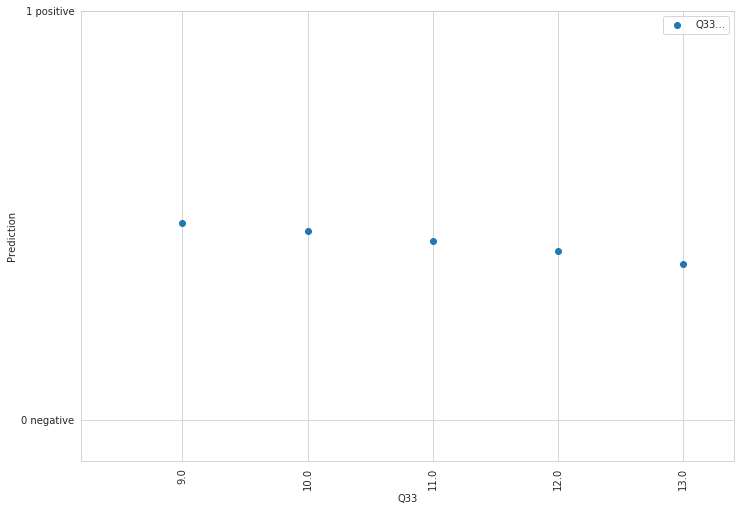

In [12]:
sns.set_style("whitegrid")
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
simulated_features = simulating_features(full_data_std, features)
sig_indicies = [i for i, p in enumerate(model.pvalues) if p <= 0.10]
sig_variables = [
    features[i]
    for i, col in enumerate(features)
    if i in sig_indicies and col not in categorical_features
]
for independent_variable in sig_variables:
    outcome_labels = ["negative", "positive"]
    outcome_choices = [0, 1]
    r_d = simulate_continuous_outcomes(
        simulated_features, model, features, independent_variable
    )
    ax.scatter(
        r_d["response_range"],
        r_d["predictions"],
        label=independent_variable[0:20] + "...",
    )
    ax.set_ylabel("Prediction")
    ax.set_xlabel(independent_variable)
    ax.set_yticks(np.sort(outcome_choices))
    ax.set_yticklabels(
        [
            str(outcome) + " " + choice
            for outcome, choice in zip(outcome_choices, outcome_labels)
        ]
    )
    ax.set_xticks(np.sort(r_d["response_range"]))
    ax.set_xticklabels(
        [
            round(
                stats[independent_variable]["std"]
                * (stats[independent_variable]["mu"] + chc)
            )
            for chc in r_d["question_choices"]
        ],
        rotation=90,
    )
    ax.legend()
    ax.set_ylim(-0.1)
    ax.set_xlim(-0.1)
# plt.savefig("sig_sum_uses.png")
plt.show()

In [15]:
mod = sm.OLS(full_data_std[[dependent_variable]], full_data_std[features]).fit()
mod = sm.OLS(full_data_std[[dependent_variable]], full_data_std[features]).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                  Q19_4   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.3624
Date:                Fri, 04 Jan 2019   Prob (F-statistic):              0.953
Time:                        16:33:47   Log-Likelihood:                -2443.9
No. Observations:                1050   AIC:                             4906.
Df Residuals:                    1041   BIC:                             4951.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Q30                   0.0392      0.07